In [16]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss, BCELoss
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
from tempfile import TemporaryDirectory
import os
from torchvision import transforms
import wandb


In [17]:
LOGGING = False

if(LOGGING):
    wandb.login(key='INSERT_YOUR_KEY')

    wandb.init(
        # set the wandb project where this run will be logged
        project="aml-challenge",
        name="evaluation-baseline",

        # track hyperparameters
        config={
        "learning_rate": 0.001,
        "architecture": "SimpleCNN",
        "epochs": 50,
        }
    )

In [18]:
# Loading training labels from csv file
import csv
train_labels = {}
with open('../input/aerial-cactus/train.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for rows in reader:
        k = rows[0]
        v = int(rows[1])
        train_labels[k] = v
        
#Check in train_labels the number of k with value 0 or 1
print("Number of images with cactus: ", sum(train_labels.values()))
print("Number of images without cactus: ", len(train_labels) - sum(train_labels.values()))

Number of images with cactus:  13136
Number of images without cactus:  4364


In [19]:
# Define custom dataset to load data
import os
from PIL import Image

class CactusDataset(Dataset):
    def __init__(self, root_dir, train_labels, sampling_strategy=None, augment=False):
        """
        Args:
            root_dir (str): Directory containing the images.
            train_labels (dict): Dictionary mapping file names to labels (0 or 1).
            sampling_strategy (str): Sampling strategy, can be 'undersample', 'oversample' or None.
            augment (bool): Whether to apply augmentation (only applies for oversampling).
        """
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)
        self.train_labels = train_labels
        self.sampling_strategy = sampling_strategy
        self.augment = augment
        self.labels = [train_labels[file] for file in self.file_list]
        
        if self.sampling_strategy == 'undersample':
            self.undersample()
        elif self.sampling_strategy == 'oversample':
            self.oversample()
        
        # Define transform for augmentation
        self.augmentation_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor()
        ])
    
    def undersample(self):
        # Find indices for each class
        class_0_idx = [idx for idx, label in enumerate(self.labels) if label == 0]
        class_1_idx = [idx for idx, label in enumerate(self.labels) if label == 1]
        
        # Balance the number of samples for each class
        num_samples_class_0 = len(class_0_idx)
        indices_to_take = np.random.choice(class_1_idx, size=num_samples_class_0, replace=False)
        samples = np.append(indices_to_take, class_0_idx)
        
        # Update file list and labels with the undersampled set
        self.file_list = [self.file_list[idx] for idx in samples]
        self.labels = [self.labels[idx] for idx in samples]
    
    def oversample(self):
        # Find indices for each class
        class_0_idx = [idx for idx, label in enumerate(self.labels) if label == 0]
        class_1_idx = [idx for idx, label in enumerate(self.labels) if label == 1]
        
        # Balance the number of samples for each class
        num_samples_class_1 = len(class_1_idx)
        num_samples_to_augment = num_samples_class_1 - len(class_0_idx)
        
        # Augment class 0 samples to match class 1
        indices_to_augment = np.random.choice(class_0_idx, size=num_samples_to_augment, replace=True)
        self.file_list += [self.file_list[idx] for idx in indices_to_augment]
        self.labels += [0] * num_samples_to_augment

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Gets the next image from the directory
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = os.path.join(self.root_dir, self.file_list[idx])
        
        # Open image and convert to numpy array
        img = Image.open(file_name)
        data = np.asarray(img).copy()
        
        # Transform image to tensor
        image = torch.from_numpy(data).permute(2, 0, 1).float()
        label = self.train_labels[self.file_list[idx]]
        
        # Apply augmentation if oversampling and class label is 0
        if label == 0 and self.augment and self.sampling_strategy == 'oversample':
            image = self.augmentation_transform(image)
        
        return image, label, file_name

In [20]:
from torch.utils.data import random_split
from torchvision.transforms import v2
from torchvision import transforms

# Need to get mean and std for each channel of the images in the train dataloaders
def get_mean_std(dataset):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = torch.tensor([0.0,0.0,0.0])
    std = torch.tensor([0.0,0.0,0.0])
    count = 0
    
    for images, _, _ in dataset:
        count += 1
        num_channels, height, width = images.shape
        num_pixels += height * width
        
        mean += images.mean(axis=(1, 2))
        std += images.std(axis=(1, 2))

    mean /= count
    std /= count

    return mean, std

dataset = CactusDataset(root_dir='../input/aerial-cactus/train/train/', train_labels=train_labels)
percentages = [0.7, 0.2, 0.1]
train, valid, test = random_split(dataset, percentages)

print(f"Train len is {len(train)}")

Train len is 12250


In [21]:
# Creating the DataLoader
BATCH_SIZE = 16
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = {'train':train_dataloader, 'valid':valid_dataloader, 'test':test_dataloader}
dataset_sizes = {'train': len(train), 'valid':len(valid), 'test':len(test)}

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  # 32 channels, image size reduced to 8x8 by 2 pooling layers
        self.fc2 = nn.Linear(128, 2)  
    
    def forward(self, x):
        # First convolutional layer followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Second convolutional layer followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        # First fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        
        return x
    
    def extract_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # Second convolutional layer followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        return x

# Define device to send to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
model = SimpleCNN().to(device)
# Print the model architecture
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [23]:
# data_transformation = transforms.Compose([
#     transforms.Normalize(mean = mean, std=std)
# ])
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    losses = {
        'train': [],
        'valid': []
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_auc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                
                total_labels = np.array([])
                total_preds = np.array([])
                total_probabilities = np.array([])

                # Iterate over data.
                for images, labels, _ in dataloaders[phase]:
                    images = images.to(device, dtype=torch.float)
                    total_labels = np.hstack([total_labels, labels.numpy()])
                    labels = labels.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        
                        # Saving probabilites for class one to then compute ROC and AUC
                        probabilities_soft = F.softmax(outputs, dim=1).cpu().detach().numpy()
                        total_probabilities = np.hstack([total_probabilities, probabilities_soft[:, 1]])
                        
                        _, preds = torch.max(outputs, 1)
                        total_preds = np.hstack([total_preds, preds.cpu().numpy()])
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() #* images.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                precision = precision_score(total_labels, total_preds)
                recall = recall_score(total_labels, total_preds)
                f1score = f1_score(total_labels, total_preds)

                # Compute ROC curve
                auc = roc_auc_score(total_labels, total_probabilities)
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1Score: {f1score:.4f}, AUC: {auc:.4f}')

                losses[phase].append(epoch_loss)
                
                if(LOGGING):
                    if phase == 'train':
                        wandb.log({'train_loss':epoch_loss, 'train_acc':epoch_acc, 'train_precision':precision, 'train_recall':recall, 'train_f1score':f1score, 'train_auc':auc})
                    else:
                        wandb.log({'valid_loss':epoch_loss, 'valid_acc':epoch_acc, 'valid_precision':precision, 'valid_recall':recall, 'valid_f1score':f1score, 'valid_auc':auc})
                
                
                # deep copy the model
                if phase == 'valid' and auc > best_auc:
                    best_auc = auc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val AUC: {best_auc:4f}')
        if(LOGGING):
            wandb.log({'best_val_auc': best_auc})

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, losses

In [24]:
#Train the model
LEARNING_RATE = 1e-3
EPOCHS = 50
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, losses = train_model(model, criterion, optimizer, exp_lr_scheduler, EPOCHS)

Epoch 0/49
----------
train Loss: 0.0200 Acc: 0.9220 Precision: 0.9417 Recall: 0.9554 F1Score: 0.9485, AUC: 0.9591
valid Loss: 0.0072 Acc: 0.9606 Precision: 0.9769 Recall: 0.9702 F1Score: 0.9735, AUC: 0.9888

Epoch 1/49
----------
train Loss: 0.0093 Acc: 0.9456 Precision: 0.9628 Recall: 0.9650 F1Score: 0.9639, AUC: 0.9806
valid Loss: 0.0113 Acc: 0.9403 Precision: 0.9284 Recall: 0.9969 F1Score: 0.9615, AUC: 0.9889

Epoch 2/49
----------
train Loss: 0.0077 Acc: 0.9532 Precision: 0.9689 Recall: 0.9690 F1Score: 0.9689, AUC: 0.9864
valid Loss: 0.0065 Acc: 0.9609 Precision: 0.9552 Recall: 0.9943 F1Score: 0.9743, AUC: 0.9938

Epoch 3/49
----------
train Loss: 0.0069 Acc: 0.9600 Precision: 0.9736 Recall: 0.9732 F1Score: 0.9734, AUC: 0.9894
valid Loss: 0.0099 Acc: 0.9380 Precision: 0.9918 Recall: 0.9247 F1Score: 0.9571, AUC: 0.9906

Epoch 4/49
----------
train Loss: 0.0056 Acc: 0.9660 Precision: 0.9763 Recall: 0.9786 F1Score: 0.9775, AUC: 0.9931
valid Loss: 0.0055 Acc: 0.9737 Precision: 0.9839 

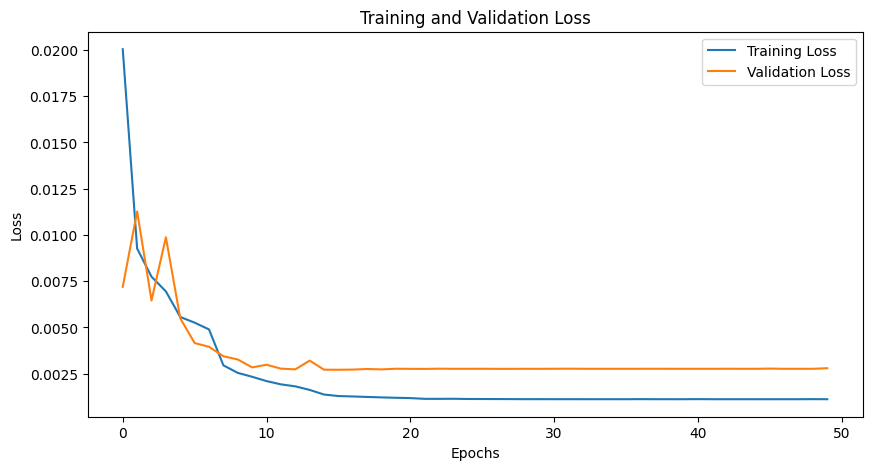

In [25]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['valid'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()